# Confidence rating analysis - Discovery Sample

## Analysis overview

#### Discovery sample

1. Model fitting: [`Model fitting - Discovery.ipynb`](<../../notebooks/discovery/Model fitting - Discovery.ipynb>)
2. **⭐ Confidence analysis: [`Confidence analysis - Discovery.ipynb`](<../../notebooks/discovery/Confidence analysis - Discovery.ipynb>)** ⭐
3. Transdiagnostic factor estimation: [`Transdiagnostic factors - Discovery.ipynb`](<../../notebooks/discovery/Transdiagnostic factors - Discovery.ipynb>)
4. Symptom-behaviour analyses: [`Symptom analyses - Discovery.ipynb`](<../../notebooks/discovery/Symptom analyses - Discovery.ipynb>)

#### Replication sample

1. Model fitting: [`Model fitting - Replication.ipynb`](<../../notebooks/replication/Model fitting - Replication.ipynb>)
2. Confidence analysis: [`Confidence analysis - Replication.ipynb`](<../../notebooks/replication/Confidence analysis - Replication.ipynb>)
3. Two-step task analysis: [`Two-step modelling - Replication.ipynb`](<../../notebooks/replication/Two-step modelling - Replication.ipynb>)
4. Transdiagnostic factor estimation: [`Transdiagnostic factors - Replication.ipynb`](<../../notebooks/replication/Transdiagnostic factors - Replication.ipynb>)
5. Symptom-behaviour analyses: [`Symptom analyses - Replication.ipynb`](<../../notebooks/replication/Symptom analyses - Replication.ipynb>)

#### Test-retest sample

1. Model-fitting: [`Model fitting - Retest.ipynb`](<../../notebooks/retest/Model fitting - Retest.ipynb>)
2. Two-step modelling: [`Two-step modelling - Retest.ipynb`](<../../notebooks/retest/Two-step modelling - Retest.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Retest.ipynb`](<../../notebooks/retest/Test-retest - Retest.ipynb>)

#### Follow-up sample

1. Model fitting: [`Model fitting - Follow up.ipynb`](<../../notebooks/follow-up/Model fitting - Follow up.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up.ipynb`](<../../notebooks/follow-up/Transdiagnostic factors - Follow up.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up.ipynb`](<../../notebooks/follow-up/Test-retest - Follow up.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses - Follow up.ipynb`](<../../notebooks/follow-up/Longitudinal analyses - Follow up.ipynb>)

#### Follow-up sample (1 year)

1. Model fitting: [`Model fitting - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Model fitting - Follow up 1yr.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Transdiagnostic factors - Follow up 1yr.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Test-retest - Follow up 1yr.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses -  Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Longitudinal analyses - Follow up 1yr.ipynb>)

## Notebook overview

During the task, we intermittently collect implicit confidence ratings (displayed to the participant as "bonus rounds"). In this notebook, we examine whether these ratings are predicted by quantities from our computational model of behaviour.

<img src="../confidence_trial.png" alt="Image Description" width="500">

On these trials, participants "bet" on the colour of the ball. They gain points if the ball colour matches the colour of the asteroid that it hits, and lose points if it does not. If they believe that the ball will be pink, they should aim at a pink asteroid, and vice versa for purple. If they are very confident in their estimate, they should aim for the asteroid with the highest value. If they are not so confident, they should aim for the asteroid with the lowest value (or shoot through the middle, in which case they hit no asteroids).

The analysis involves fitting three models:

1. **Model 1**: Subjects' choice of pink or purple is predicted by the transition probability estimate. This serves to ensure that the model is indeed able to predict subjects' choices of pink versus purple when they are explictly asked to predict which colour ball they will get.
2. **Model 2**: This model predicts subjects' confidence (i.e., their choice of high or low stakes) based on different types of uncertainty from this model. This enables us to determine whether confidence is predicted by uncertainty in the transition probabilities.
3. **Model 3**: This model is similar to the model above, but excludes the uncertainy measures. This provides an "adjusted" confidence metric that accounts for effects of task practice and the scaling of the bet amounts, which can be used for further analyses.


In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"

import numpyro

numpyro.set_host_device_count(
    4
)  # Set this to the number of cores you want to use
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from stats_utils.bayesian.plotting import plot_posteriors
from stats_utils.bayesian.utils import arviz_to_markdown_table

from transition_uncertainty.style import set_style
from transition_uncertainty.utils import (
    check_directories,
    save_markdown_tables,
)

# Raise an error if we're not in the root directory by checking if the data folder exists
check_directories()

set_style("style.mplstyle")

# Make sure we use the CPU
import jax

assert (
    str(list(jax.numpy.ones(3).devices())[0]) == "TFRT_CPU_0"
), "CPU not being used by Jax - this is wrong"

/scratch/users/user/miniconda3/envs/tu_test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/users/user/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo


## Load in data

Here we load in the `cannonball_task_data_with_model_values.csv` produced in the model fitting notebook. This contains trial-by-trial responses alongside model-predicted quantities on each trial.


In [2]:
# Load the data from a CSV file
data = pd.read_csv(
    "results/discovery/transition-task_model-fit/cannonball_task_data_with_model_values.csv"
)

# Create a new column 'transition_irr_uncertainty' which stores the absolute
# deviation of 'transition_mean' from 0.5 (i.e., peak uncertainty)
data["transition_irr_uncertainty"] = np.abs(data["transition_mean"] - 0.5)

# Create a new column 'confidence_abs' which holds the absolute value of
# 'confidence',
data["confidence_abs"] = np.abs(data["confidence"])

# Load 'available_side' data, which indicates which side was available for the
# subject
task_spec_dir = "data/task_spec"
available_side = np.load(f"{task_spec_dir}/available_side.npy")

# Create a new column 'available_side' in 'data' dataframe. This is created by
# repeating and adjusting the loaded 'available_side' to match the length of
# unique 'subjectID's, then adding 1, thus mapping the original values [0, 1]
# to [1, 2] respectively.
data["available_side"] = (
    np.tile(available_side, len(data["subjectID"].unique())).squeeze() + 1
)

# Extract and store rows of 'data' where 'trialType' is "confidence" into a new
# dataframe 'confidence_data', effectively filtering the data for trials of
# type "confidence".
confidence_data = data[data["trialType"] == "confidence"].copy()

# Create a new column 'pink_or_purple' which is a binary representation of
# whether 'confidence' is above 0. Presumably, if 'confidence' > 0, it's
# "pink", else "purple".
confidence_data["pink_or_purple"] = (confidence_data["confidence"] > 0).astype(
    int
)

## MODEL 1

This is primarily just to check that our model-predicted transition estimates map on to subjects' actual responses when asked to choose between pink and purple.

### Model Specification

The model can be mathematically represented as:

\begin{equation}
\text{logit}(P(\text{pink\_or\_purple} = 1)) = \beta_0 + \beta_1 \cdot \text{transition\_mean} + b_0^{(\text{subjectID})} + b_1^{(\text{subjectID})} \cdot \text{transition\_mean}
\end{equation}

### Description of the terms:
- $\text{pink\_or\_purple}$: Binary outcome variable indicating the probability of the event (1 if pink or purple, 0 otherwise).
- $\text{logit}(P(\text{pink\_or\_purple} = 1))$: The log-odds of the probability that the outcome is pink or purple.
- $\beta_0$: The fixed intercept of the model.
- $\beta_1$: The fixed effect coefficient for the predictor $\text{transition\_mean}$.
- $b_0^{(\text{subjectID})}$: The random intercept for each subject, capturing subject-specific deviations from the fixed intercept.
- $b_1^{(\text{subjectID})}$: The random slope for $\text{transition\_mean}$ within each subject, capturing subject-specific deviations from the fixed slope.
- $\text{transition\_mean}$: A continuous predictor variable.
- $\text{subjectID}$: The grouping factor for the random effects, indicating that intercepts and slopes vary by subject.

### Explanation

-   **Outcome Variable**: `pink_or_purple` - A binary outcome representing whether the participant chose pink or purple.
-   **Predictor Variable**: `transition_mean` - The estimated likelihood of observing a purple ball, as predicted by the model.
-   **Random Effects**: Both intercept and slope for `transition_mean` are treated as random effects, allowing these parameters to vary across different levels of `subjectID`.
-   **Link Function**: The logistic (logit) link function is applied to relate the linear predictor to the mean of the Bernoulli distribution, ensuring the output to be in the (0, 1) range suitable for probability prediction.
-   **Distribution of Dependent Variable**: It is assumed that the outcome variable follows a Bernoulli distribution, suitable for binary outcomes.

We use the NUTS sampler from [NumPyro](http://num.pyro.ai/en/stable/) to sample from the posterior distribution of the model parameters as it is faster than the PyMC sampler.


In [3]:
# List of column names to scale. These variables will be standardized in the DataFrame.
columns_to_scale = [
    "trial",
    "betScaling",
    "transition_irr_uncertainty",
    "transition_var",
    "confidence_abs",
    "confidence",
]

# Create a copy of the original data. This ensures that the original DataFrame,
# `confidence_data`, is not modified when `confidence_data_scaled` is altered.
confidence_data_scaled = confidence_data.copy()

# Invert transition_mean where available_side is 1
confidence_data_scaled.loc[
    confidence_data_scaled["available_side"] == 1, "transition_mean"
] = (
    1
    - confidence_data_scaled.loc[
        confidence_data_scaled["available_side"] == 1, "transition_mean"
    ]
)

# Standardize selected columns in the DataFrame. `apply` applies the lambda
# function to each column specified, which in this context, subtracts the
# column mean and divides by the column standard deviation (z-score scaling).
confidence_data_scaled[columns_to_scale] = confidence_data[
    columns_to_scale
].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Construct a Bernoulli model using the `bmb.Model` constructor.
model_1 = bmb.Model(
    "pink_or_purple ~ 1 + transition_mean + (1|subjectID) + (transition_mean|subjectID)",
    confidence_data_scaled[confidence_data_scaled["confidence"] != 0],
    family="bernoulli",
)

# Fit the model, specifying a random seed for reproducibility, using 4 Markov
# chains in the fitting process, and setting a target acceptance rate of 0.85
# for the NUTS algorithm. `results_1` will store the fitted model object
# including estimated parameters.
results_1 = model_1.fit(
    draws=8000,
    tune=2000,
    chains=4,
    cores=4,
    random_seed=42,
    target_accept=0.85,
    inference_method="nuts_numpyro",
)

Modeling the probability that pink_or_purple==1
Compiling.. :   0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]





Running chain 0:   0%|                                                                                                                                   | 0/10000 [00:03<?, ?it/s]


Running chain 0:   5%|██████                                                                                                                   | 500/10000 [00:34<09:56, 15.93it/s]




Running chain 0:   5%|██████                                                                                                                   | 500/10000 [00:49<09:56, 15.93it/s]

Running chain 0:  10%|████████████                                                                                                            | 1000/10000 [00:57<07:56, 18.89it/s]


Running chain 0:  10%|████████████    

#### Run diagnostics

The R-hat statistic, denoted as `az.rhat` in the code, is used for diagnosing the convergence of Markov Chain Monte Carlo (MCMC) chains in Bayesian analysis. It informs us whether the chains have mixed well and converged to the target distribution. Ideally, R-hat should be close to 1, ensuring that inferences made from the sample are reliable and the chains have converged properly, validating the robustness of the modeling process.


In [4]:
# Run diagnostics
az.rhat(results_1)

<xarray.Dataset>
Dimensions:                          (subjectID__factor_dim: 600)
Coordinates:
  * subjectID__factor_dim            (subjectID__factor_dim) <U7 'sub-001' .....
Data variables:
    Intercept                        float64 1.001
    transition_mean                  float64 1.001
    1|subjectID_sigma                float64 1.006
    transition_mean|subjectID_sigma  float64 1.005
    1|subjectID                      (subjectID__factor_dim) float64 1.001 .....
    transition_mean|subjectID        (subjectID__factor_dim) float64 1.0 ... ...

#### View summary

Here we view the summary of the model fit, providing the mean, standard deviation, and 95% highest posterior density intervals for each parameter.


In [5]:
az.summary(
    results_1, var_names=["transition_mean"], kind="stats", hdi_prob=0.95
)

,mean,sd,hdi_2.5%,hdi_97.5%
transition_mean,8.828,0.271,8.3,9.362


#### Plot posterior

We can also plot the posterior distributions of the parameters of interest. Here we only care about the effect of `transition_mean`.


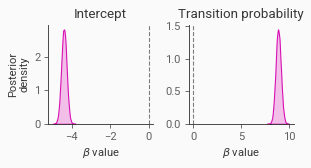

In [6]:
plot_posteriors(
    results_1,
    ["Intercept", "transition_mean"],
    ["Intercept", "Transition probability"],
)

### Save model

Finally, we save the ArViz `InferenceData` object to disk.


In [7]:
# Save Arviz inferencedata to a file
if not os.path.exists("results/discovery/confidence_model-fit"):
    os.makedirs("results/discovery/confidence_model-fit")

az.to_netcdf(results_1, "results/discovery/confidence_model-fit/model-1.nc")

'results/discovery/confidence_model-fit/model-1.nc'

## MODEL 2

Here we construct a GLM predicting absolute confidence ratings from the following regressors:

-   **trial**: Trial number, to account for general trends in confidence over the course of the task
-   **betScaling**: The scale of the values on which the bet was placed
-   **transition_irr_uncertainty**: Irreducible uncertainty of the estimated transition probability (i.e., how far away from 0.5 the estimated transition probability is)
-   **transition_var**: Variance of the estimated transition probability

Again, we use a hierarchical model, assuming subject-specific intercepts and slopes.


In [8]:
# Create a copy of `confidence_data` to avoid modifying the original DataFrame
# while scaling.
confidence_data_scaled = confidence_data.copy()

# Specify columns that will be scaled
columns_to_scale = [
    "trial",
    "betScaling",
    "transition_irr_uncertainty",
    "transition_var",
    "confidence_abs",
]

# Explicitly list columns used in the modeling to avoid errors due to any
# possible missing columns.
confidence_data_scaled = confidence_data_scaled[
    [
        "subjectID",
        "trial",
        "betScaling",
        "transition_irr_uncertainty",
        "transition_var",
        "confidence_abs",
    ]
]

# Standardize the specified columns to have zero mean and unit variance
confidence_data_scaled[columns_to_scale] = (
    confidence_data[columns_to_scale]
    - confidence_data[columns_to_scale].mean()
) / confidence_data[columns_to_scale].std()

# Scale confidence_abs to be within 0.001 and 0.999 to fit the requirement of
# certain models, such as beta regression. minmax_scale transforms features by
# scaling each feature to a given range.
confidence_data_scaled["confidence_abs"] = minmax_scale(
    confidence_data_scaled["confidence_abs"], feature_range=(0.001, 0.999)
)

# Define and fit a hierarchical Bayesian GLM (Generalized Linear Model) using
# Bambi. Here, '1 +' in the formula means that we are estimating an intercept
# for the fixed effects. The terms in the parentheses indicate random effects
# for `subjectID`. A Beta distribution is used to model the dependent variable
# `confidence_abs`.
model_2 = bmb.Model(
    "confidence_abs ~ 1 + trial + betScaling + transition_irr_uncertainty + "
    "transition_var + (1|subjectID) + (trial|subjectID) + (betScaling|subjectID) + "
    "(transition_irr_uncertainty|subjectID) + (transition_var|subjectID)",
    confidence_data_scaled,
    family="beta",
)

# Fit the model using Markov Chain Monte Carlo (MCMC) sampling.
# - draws: number of samples from the posterior
# - tune: number of iterations to tune the sampler
# - chains: number of Markov chains to run
# - target_accept: target acceptance rate for step-size adaptation
# - inference_method: inference method used by the model ('nuts_numpyro'
#   indicates we're using NumPyro's NUTS sampler)
results_2 = model_2.fit(
    draws=8000,
    tune=2000,
    chains=4,
    random_seed=42,
    target_accept=0.85,
    inference_method="nuts_numpyro",
)

# Store the markdown table in a variable
results_2_table = arviz_to_markdown_table(
    results_2,
    var_names=[
        "trial",
        "betScaling",
        "transition_irr_uncertainty",
        "transition_var",
    ],
    predictor_rename_dict={
        "trial": "Trial",
        "betScaling": "Bet scaling",
        "transition_irr_uncertainty": "Irreducible uncertainty",
        "transition_var": "Reducible variance",
    },
)

Compiling.. :   0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]






Running chain 0:   0%|                                                                                                                                   | 0/10000 [00:07<?, ?it/s]




Running chain 0:   5%|█████▉                                                                                                                 | 500/10000 [06:34<2:02:24,  1.29it/s]


Running chain 0:  10%|███████████▊                                                                                                          | 1000/10000 [08:20<1:06:29,  2.26it/s]


Running chain 0:  15%|██████████████████                                                                                                      | 1500/10000 [09:43<44:56,  3.15it/s]


Running chain 0:  20%|████████████████████████                                      

#### Run diagnostics


In [9]:
# Run diagnostics
az.rhat(results_2)

<xarray.Dataset>
Dimensions:                                     (subjectID__factor_dim: 600)
Coordinates:
  * subjectID__factor_dim                       (subjectID__factor_dim) <U7 '...
Data variables: (12/16)
    Intercept                                   float64 1.003
    trial                                       float64 1.0
    betScaling                                  float64 1.0
    transition_irr_uncertainty                  float64 1.0
    transition_var                              float64 1.001
    confidence_abs_kappa                        float64 1.0
    ...                                          ...
    transition_var|subjectID_sigma              float64 1.001
    1|subjectID                                 (subjectID__factor_dim) float64 ...
    trial|subjectID                             (subjectID__factor_dim) float64 ...
    betScaling|subjectID                        (subjectID__factor_dim) float64 ...
    transition_irr_uncertainty|subjectID        (subjectID__factor_dim) float64 ...
    transition_var|subjectID                    (subjectID__factor_dim) float64 ...

#### View summary


In [10]:
summary = az.summary(
    results_2,
    var_names=[
        "trial",
        "betScaling",
        "transition_irr_uncertainty",
        "transition_var",
    ],
    hdi_prob=0.95,
)

# Display summary
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trial,-0.006,0.016,-0.037,0.024,0.0,0.0,12220.0,18138.0,1.0
betScaling,-0.010,0.009,-0.028,0.007,0.0,0.0,43072.0,22533.0,1.0
transition_irr_uncertainty,0.055,0.017,0.022,0.087,0.0,0.0,17301.0,21286.0,1.0
transition_var,-0.177,0.032,-0.240,-0.115,0.0,0.0,5830.0,10390.0,1.0


#### Plot posteriors


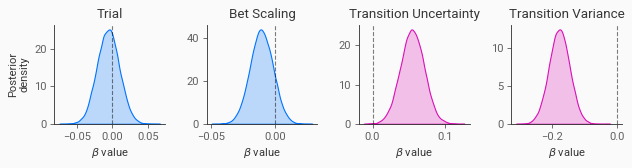

In [11]:
plot_posteriors(
    results_2,
    ["trial", "betScaling", "transition_irr_uncertainty", "transition_var"],
    ["Trial", "Bet Scaling", "Transition Uncertainty", "Transition Variance"],
)

#### Save results


In [12]:
# Save Arviz inferencedata to a file
az.to_netcdf(results_2, "results/discovery/confidence_model-fit/model-2.nc")

'results/discovery/confidence_model-fit/model-2.nc'

## MODEL 3

This model essentially replicates Model 2, but without the uncertainty effects. The subject-level intercepts from this model should give us an idea of subjects' general level of confidence that accounts for time-on-task and bet scaling effects, but not uncertainty effects. This can be useful in further analyses where we want to determine whether confidence is related to symptoms.


In [13]:
# Create a copy of `confidence_data` to avoid modifying the original DataFrame
# while scaling.
confidence_data_scaled = confidence_data.copy()

# Specify columns that will be scaled
columns_to_scale = [
    "trial",
    "betScaling",
    "confidence_abs",
]

# Explicitly list columns used in the modeling to avoid errors due to any
# possible missing columns.
confidence_data_scaled = confidence_data_scaled[
    [
        "subjectID",
        "trial",
        "betScaling",
        "confidence_abs",
    ]
]

# Standardize the specified columns to have zero mean and unit variance
confidence_data_scaled[columns_to_scale] = (
    confidence_data[columns_to_scale]
    - confidence_data[columns_to_scale].mean()
) / confidence_data[columns_to_scale].std()

# Scale confidence_abs to be within 0.001 and 0.999 to fit the requirement of
# certain models, such as beta regression. minmax_scale transforms features by
# scaling each feature to a given range.
confidence_data_scaled["confidence_abs"] = minmax_scale(
    confidence_data_scaled["confidence_abs"], feature_range=(0.001, 0.999)
)

# Define and fit a hierarchical Bayesian GLM (Generalized Linear Model) using Bambi.
model_3 = bmb.Model(
    "confidence_abs ~ 1 + trial + betScaling"
    " + (1|subjectID) + (trial|subjectID) + (betScaling|subjectID)",
    confidence_data_scaled,
    family="beta",
)

# Fit the model using Markov Chain Monte Carlo (MCMC) sampling.
# - draws: number of samples from the posterior
# - tune: number of iterations to tune the sampler
# - chains: number of Markov chains to run
# - target_accept: target acceptance rate for step-size adaptation
# - inference_method: inference method used by the model ('nuts_numpyro'
#   indicates we're using NumPyro's NUTS sampler)
results_3 = model_3.fit(
    draws=8000,
    tune=2000,
    chains=4,
    cores=4,
    random_seed=42,
    target_accept=0.85,
    inference_method="nuts_numpyro",
)

Compiling.. :   0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]





Running chain 0:   0%|                                                                                                                                   | 0/10000 [00:05<?, ?it/s]





Running chain 0:   5%|█████▉                                                                                                                 | 500/10000 [05:12<1:37:14,  1.63it/s]


Running chain 0:  10%|████████████                                                                                                            | 1000/10000 [06:14<48:48,  3.07it/s]


Running chain 0:  15%|██████████████████                                                                                                      | 1500/10000 [07:12<32:32,  4.35it/s]


Running chain 0:  20%|████████████████████████                                      

#### Run diagnostics


In [14]:
# Run diagnostics
az.rhat(results_3)

<xarray.Dataset>
Dimensions:                     (subjectID__factor_dim: 600)
Coordinates:
  * subjectID__factor_dim       (subjectID__factor_dim) <U7 'sub-001' ... 'su...
Data variables:
    Intercept                   float64 1.0
    trial                       float64 1.0
    betScaling                  float64 1.0
    confidence_abs_kappa        float64 1.0
    1|subjectID_sigma           float64 1.0
    trial|subjectID_sigma       float64 1.0
    betScaling|subjectID_sigma  float64 1.0
    1|subjectID                 (subjectID__factor_dim) float64 1.0 1.0 ... 1.0
    trial|subjectID             (subjectID__factor_dim) float64 1.001 ... 1.0
    betScaling|subjectID        (subjectID__factor_dim) float64 0.9999 ... 1.0

#### Plot intercepts


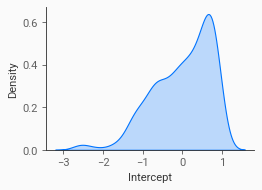

In [15]:
subject_intercepts = (
    results_3.posterior["1|subjectID"].mean(dim=["chain", "draw"]).values
)

plt.figure(figsize=(3, 2.2))
sns.kdeplot(subject_intercepts, fill=True)
plt.xlabel("Intercept")

# Removing the top and right spines from plots for aesthetics
sns.despine()

#### Save results


In [16]:
# Save Arviz inferencedata to a file
az.to_netcdf(results_3, "results/discovery/confidence_model-fit/model-3.nc")

'results/discovery/confidence_model-fit/model-3.nc'

### Extract parameter values for further analysis

Finally, we take subject-level parameters from these models to use in further analyses.


In [17]:
mean_confidence = (
    confidence_data[["subjectID", "confidence_abs"]]
    .groupby("subjectID")
    .mean()
    .reset_index()
)

confidence_param_df = {
    "subjectID": data["subjectID"].unique(),
    "beta_trial": results_2.posterior["trial|subjectID"].mean(
        dim=["chain", "draw"]
    ),
    "beta_betScaling": results_2.posterior["betScaling|subjectID"].mean(
        dim=["chain", "draw"]
    ),
    "beta_transition_irr_uncertainty": results_2.posterior[
        "transition_irr_uncertainty|subjectID"
    ].mean(dim=["chain", "draw"]),
    "beta_transition_var": results_2.posterior[
        "transition_var|subjectID"
    ].mean(dim=["chain", "draw"]),
    "average_confidence": mean_confidence["confidence_abs"].values,
    "adjusted_confidence": subject_intercepts,
}

# Save
confidence_param_df = pd.DataFrame(confidence_param_df)
confidence_param_df.to_csv(
    "results/discovery/confidence_model-fit/confidence_param_df.csv",
    index=False,
)

confidence_param_df.head()

,subjectID,beta_trial,beta_betScaling,beta_transition_irr_uncertainty,beta_transition_var,average_confidence,adjusted_confidence
0,sub-001,-0.227152,-0.000724,-0.000259,0.000694,3.933333,0.403626
1,sub-002,-0.109300,0.002171,0.000686,0.000113,4.566667,0.665875
2,sub-003,-0.282296,-0.000139,0.000712,-0.002278,1.933333,-0.915533
3,sub-004,0.435664,0.000206,0.001597,-0.001043,2.766667,-0.585285
4,sub-005,-0.151601,-0.000040,-0.000285,-0.002032,1.800000,-1.094560


### Save results tables as Markdown

In [19]:
# Create the caption with proper formatting
caption = (
    "Coefficients for Bayesian regression model predicting confidence "
    "from model-derived uncertainty metrics in the **discovery** sample. "
    "$\\mu$ = posterior mean, $\\sigma$ = posterior standard deviation, "
    "$HDI_{2.5}$ = 2.5% highest density interval, "
    "$HDI_{97.5}$ = 97.5% highest density interval."
)

# Save the markdown tables with the caption
if not os.path.exists('paper'):
    os.makedirs('paper')

save_markdown_tables(
    [results_2_table],
    [caption],
    "paper/supplementary_tables.md",
    prepend_string="# Supplementary tables",
)

Creating or overwriting file: paper/supplementary_tables.md
Conversion to PDF completed successfully.
Conversion to docx completed successfully.
